In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sacc
import yaml

In [2]:
path = "/home/jaimerz/Documents/UCL/HSC-PDR1-3x2pt-harmonic-methods/data/harmonic/txpipe/source_s16a_lens_dr1/all-fields/dndz/"
DS_s = sacc.Sacc.load_fits(path+"summary_statistics_fourier_all_SourcesS16A_LensesDR1_pz_mc_eab_HikageShearSC_DESC_GCandGGL_SC_kmax_0.15_1.471COVMAT.sacc")

In [3]:
DS_nzs = {}
for (name, tracer) in DS_s.tracers.items():
    DS_nzs[name] = [tracer.z, tracer.nz]

In [4]:
path = 'data/HSC/DESwl_final_HSC_cls_NzMarg_cov_p5.0_area2_diag4.0.fits'
CGG_s = sacc.Sacc.load_fits(path)

In [5]:
covs_carlos = np.load('data/HSC/DESwl_final_HSC_covNzMarg_p5.0_diag4.0.npz')
nzs_TQ = np.load('data/HSC/HSC_nzs_TQ.npz')

In [43]:
CGG_nzs = {}
for i, (name, tracer) in enumerate(CGG_s.tracers.items()):
    print(name)
    z = tracer.z[:100]
    nz = tracer.nz[:100]
    dndz = nz*np.mean(np.diff(z))
    norm = np.sum(dndz)
    dndz /= norm
    cov = covs_carlos['cov_nz'][100*i:100*(i+1)][:, 100*i:100*(i+1)][:100][:,:100]
    cov = cov/norm**2
    CGG_nzs[name] = [z, dndz, cov]

DESwl__0
DESwl__1
DESwl__2
DESwl__3
HSC__0
HSC__1
HSC__2
HSC__3


In [51]:
CGG_nzs['HSC__0'][2]

array([[ 3.43883652e-06, -3.66592561e-09, -9.84087038e-09, ...,
         2.42901702e-12, -4.35293067e-11, -2.29690789e-11],
       [-3.66592561e-09,  4.10682812e-06, -2.84627724e-08, ...,
         1.17499556e-11, -9.03536061e-11, -4.82058128e-11],
       [-9.84087038e-09, -2.84627724e-08,  5.84594663e-05, ...,
         1.19612012e-10, -6.00129462e-10, -3.11899029e-10],
       ...,
       [ 2.42901702e-12,  1.17499556e-11,  1.19612012e-10, ...,
         1.66029812e-07,  2.29071946e-09,  4.13805246e-10],
       [-4.35293067e-11, -9.03536061e-11, -6.00129462e-10, ...,
         2.29071946e-09,  7.91002593e-07,  6.96516935e-09],
       [-2.29690789e-11, -4.82058128e-11, -3.11899029e-10, ...,
         4.13805246e-10,  6.96516935e-09,  5.28884691e-07]])

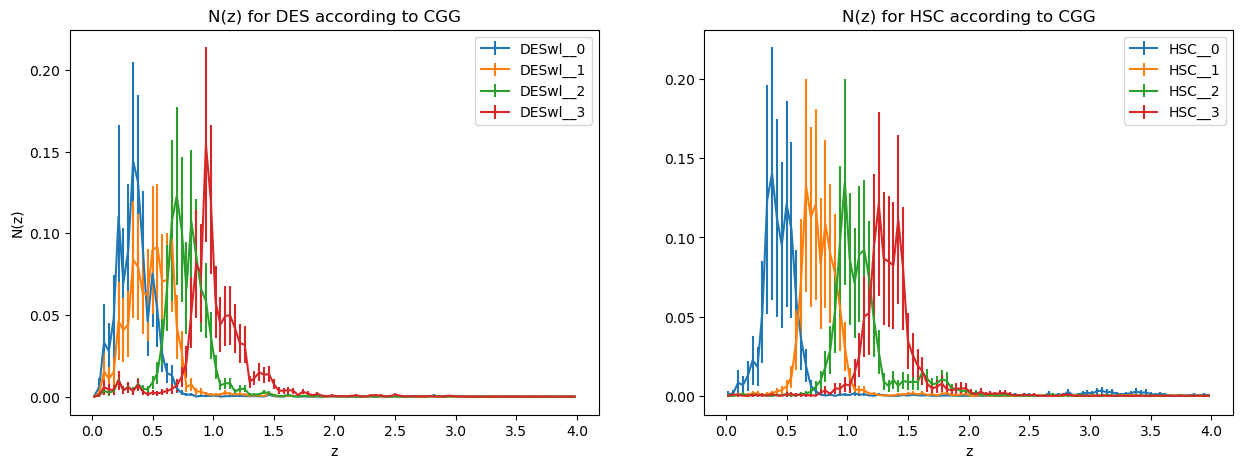

In [44]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
for (name, nz) in CGG_nzs.items():
    if 'DES' in name:
        axes[0].errorbar(nz[0], nz[1], yerr=np.sqrt(np.diag(nz[2])), label=name)
        axes[0].legend()
        axes[0].set_xlabel('z')
        axes[0].set_ylabel('N(z)')
        axes[0].set_title('N(z) for DES according to CGG')
    if 'HSC' in name:
        axes[1].errorbar(nz[0], nz[1], yerr=np.sqrt(np.diag(nz[2])), label=name)
        axes[1].legend()
        axes[1].set_xlabel('z')
        axes[1].set_title('N(z) for HSC according to CGG')
plt.show()

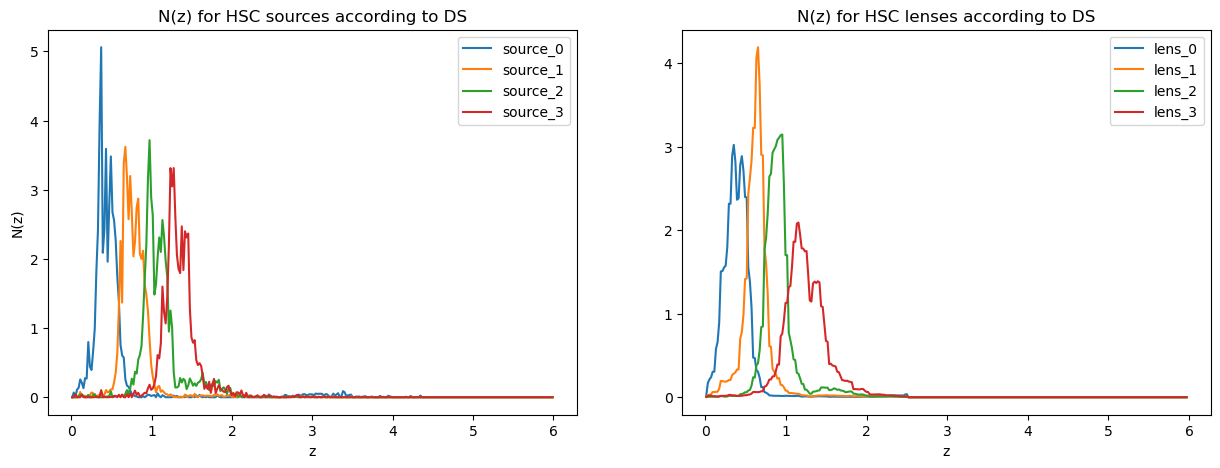

In [9]:
figure, axes = plt.subplots(1, 2, figsize=(15, 5))
for (name, nz) in DS_nzs.items():
    if 'lens' in name:
        axes[1].plot(nz[0], nz[1], label=name)
        axes[1].legend()
        axes[1].set_xlabel('z')
        axes[1].set_title('N(z) for HSC lenses according to DS')

    else:
        axes[0].plot(nz[0], nz[1], label=name)
        axes[0].legend()
        axes[0].set_xlabel('z')
        axes[0].set_ylabel('N(z)')
        axes[0].set_title('N(z) for HSC sources according to DS')

plt.legend()
plt.show()

## Post-process Carlos

In [10]:
def make_sym(A):
    return np.maximum(A, A.transpose())

/tmp/ipykernel_18884/4160077093.py:12: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


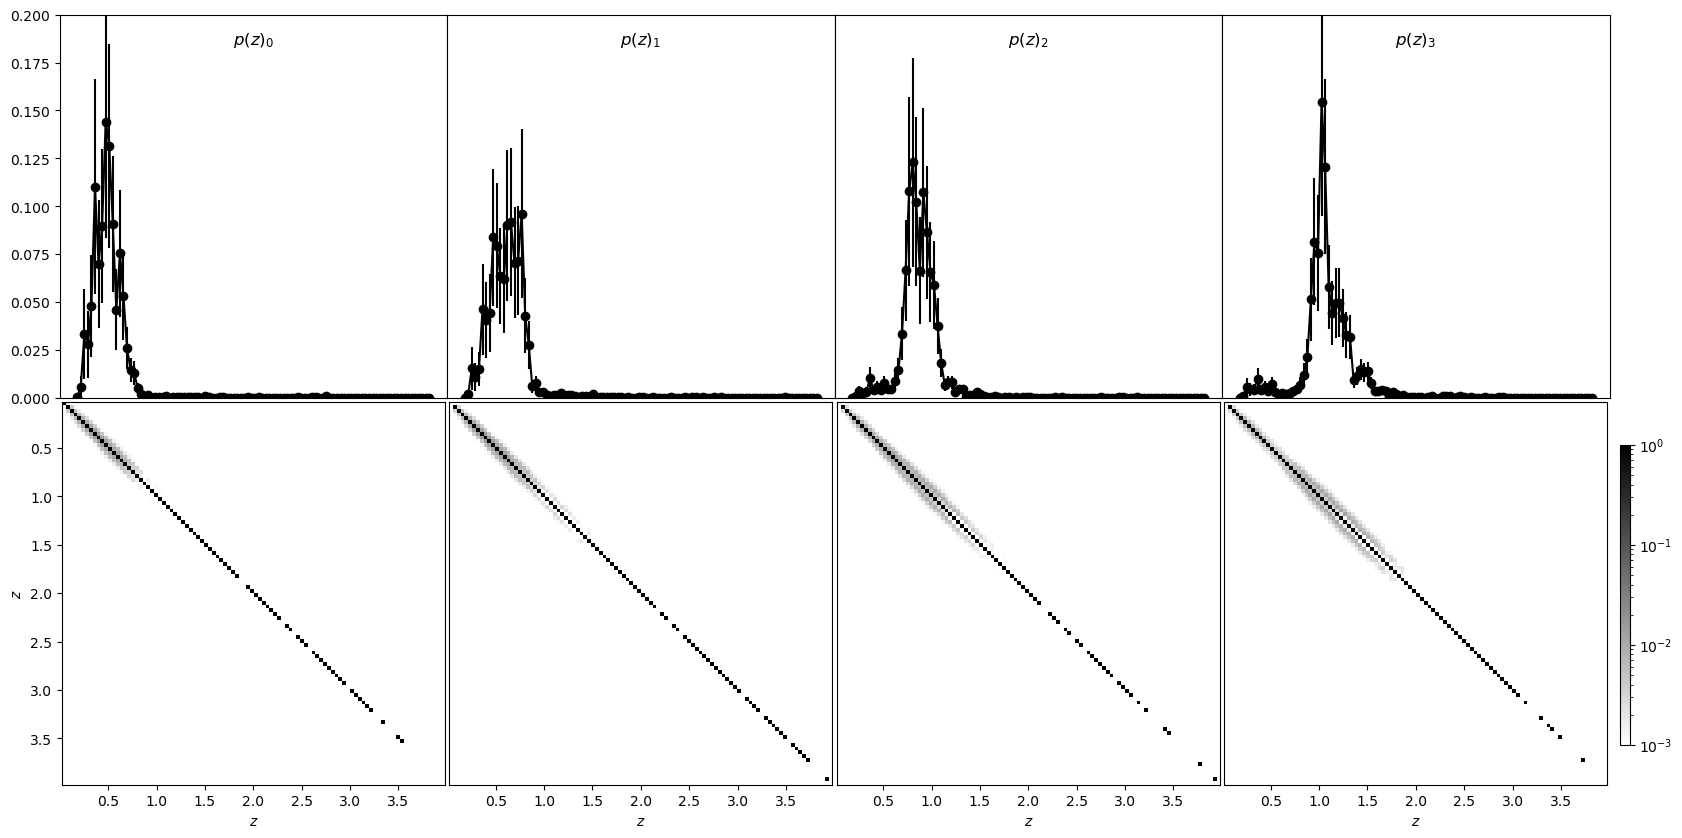

In [47]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for (name, nz) in CGG_nzs.items():
    if 'DES' in name:
        z = nz[0]
        dndz = nz[1]
        cov = nz[2]
        err = np.sqrt(np.diag(cov))
        corr = cov / (np.outer(err, err))
        axis[0 , i].errorbar(z, dndz, yerr=err,
                            fmt='{}o-'.format(colorss[i]), label="$DESY1wl_{}$".format(i))
        axis[0, i].set_ylim(0, 0.2)
        axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
        axis[0, i].set_xticks([])
        im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                           extent=[min(z), max(z), max(z), min(z)])
        axis[1, i].set_xlabel(r"$z$")
        if i > 0:
            axis[0, i].set_yticks([])
            axis[1, i].set_yticks([])
        else:
            axis[1, i].set_ylabel(r"$z$")
        i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()


100
100
100
100


/tmp/ipykernel_18884/697630612.py:13: RuntimeWarning: invalid value encountered in divide
  corr = cov / (np.outer(err, err))


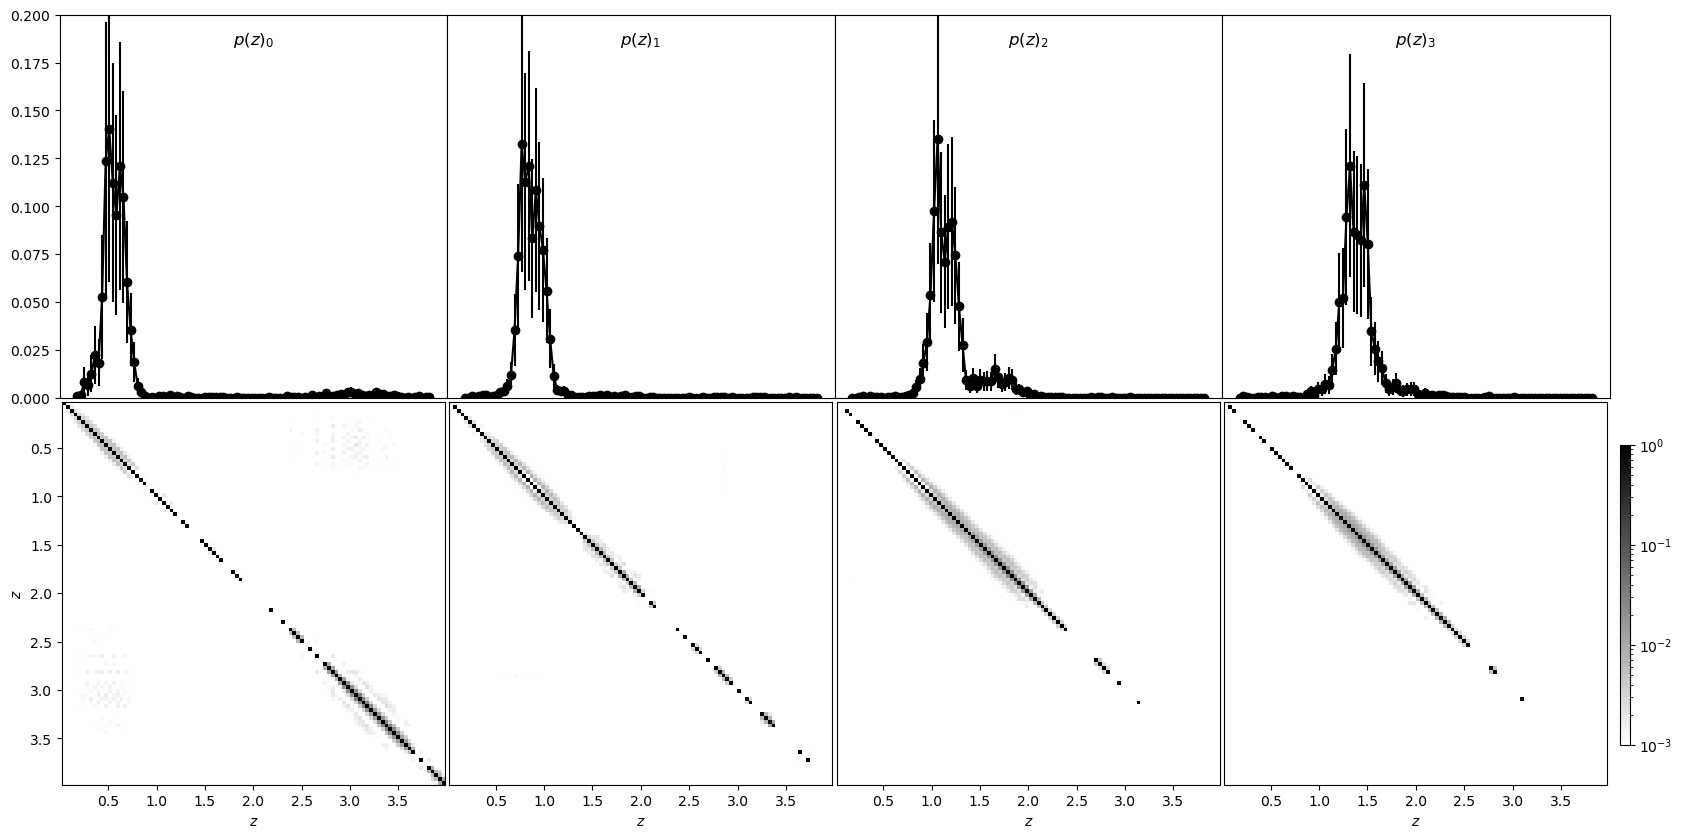

In [48]:
from matplotlib.colors import LogNorm
colorss = ["k", "k", "k", "k"]
figure, axis = plt.subplots(2, 4, figsize=(20,10))
figure.subplots_adjust(wspace=0, hspace=0.01)
i = 0
for (name, nz) in CGG_nzs.items():
    if 'HSC' in name:
        print(len(nz[0]))
        z = nz[0]
        dndz = nz[1]
        cov = nz[2]
        err = np.sqrt(np.diag(cov))
        corr = cov / (np.outer(err, err))
        axis[0 , i].errorbar(z, dndz, yerr=err,
                            fmt='{}o-'.format(colorss[i]), label="$DESY1wl_{}$".format(i))
        axis[0, i].set_ylim(0, 0.2)
        axis[0, i].set_title(r"$p(z)_{}$".format(i), y=0.9)
        axis[0, i].set_xticks([])
        im = axis[1, i].imshow(abs(corr), cmap='gray_r', norm=LogNorm(vmin=0.001, vmax=1),
                           extent=[min(z), max(z), max(z), min(z)])
        axis[1, i].set_xlabel(r"$z$")
        if i > 0:
            axis[0, i].set_yticks([])
            axis[1, i].set_yticks([])
        else:
            axis[1, i].set_ylabel(r"$z$")
        i += 1

cbar_ax = figure.add_axes([0.905, 0.15, 0.005, 0.3])
figure.colorbar(im, cax=cbar_ax)
plt.show()